# Bioconductor analisis

##### Setup olivia

In [156]:
# Olivia Finder requirements
%pip install -r ../olivia/requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [157]:
import pandas as pd
import tqdm
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import os
from time import time
import networkx as nx
import psutil
from collections import Counter

# Append the path to the olivia_finder package
import sys
sys.path.append('../../olivia/')

from olivia.model import OliviaNetwork


Set up variables

In [158]:
REPO_NAME = "Bioconductor"
OUT_IMG_DIR = f"../img/{REPO_NAME}"

# Create output directory
if not os.path.exists(OUT_IMG_DIR):
    os.makedirs(OUT_IMG_DIR)



#### **Utilities**

In [159]:

def add_chunk(
    df, G, dependent_field, dependency_field,
    filter_field=None,
    filter_value=None
):
    """ Utility method for build_dependency_network"""
    filtered = df[df[filter_field] == filter_value] if filter_field else df
    links = list(zip(filtered[dependency_field], filtered[dependent_field]))
    G.add_edges_from(links)
    return G

def build_dependency_network(
    df,
    chunk_size,
    dependent_field: str = 'Project Name',
    dependency_field: str = 'Dependency Name',
    filter_field=None,
    filter_value=None,
    verbose: bool = True
):
    # Print only if verbose
    vprint = print if verbose else lambda *a, **k: None
    process = psutil.Process(os.getpid())
    vprint("Using process ", process)
    t = time()
    try:
        vprint('Initializing graph... ', end='')
        # New NetworkX directed Graph
        G = nx.DiGraph()
        vprint('OK')
        
        # Split DataFrame into chunks
        chunks = [df[i:i + chunk_size] for i in range(0, len(df), chunk_size)]
        
        for i, chunk in enumerate(chunks):
            # Add dependencies from chunk to G
            add_chunk(
                chunk, 
                G,
                dependent_field=dependent_field,
                dependency_field=dependency_field,
                filter_field=filter_field,
                filter_value=filter_value
            )
            vprint(f'{round(i*chunk_size/1e6,1)}M lines | {len(G)} nodes, {len(G.edges)} deps. ({int(time()-t)}s) {round(process.memory_info().rss/1e6,1)}Mb')
        vprint('Done processing DataFrame')
        
        return G
    
    except Exception as e:
        print('\n', e)

def plot_degree_distribution(G, title, color, save=False, filename=None):
    '''
    Plot the degree distribution of a networkx graph
    '''

    # Nodes' degree vector
    degree=[x[1] for x in G.degree()]
    
    # Create subplots
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))

    # Set title
    fig.suptitle(title, fontsize=20, fontweight='bold')
    
    # Plot linear histogram
    # Order nodes' degree vector
    sorted_degree = sorted(degree, reverse=True)
    axs[0].plot(sorted_degree, color=color)
    axs[0].set_xlabel('Nodes')
    axs[0].set_ylabel('Degree')
    axs[0].set_yscale('log')
    
    
    # Plot histogram with log scale
    axs[1].hist(degree, bins=100, color=color)
    axs[1].set_xlabel('Degree')
    axs[1].set_ylabel('Number of nodes')
    axs[1].set_xscale('log')
    axs[1].set_yscale('log')

    # Save figure
    if save:
        plt.savefig(filename, bbox_inches='tight')
    
    plt.show()

def draw_networkx_graph(G, layout='circular', size=(20,20)):
    '''
    Draw a networkx graph
    '''

    layouts = {
        'circular': nx.circular_layout,
        'kamada_kawai': nx.kamada_kawai_layout,
        'random': nx.random_layout,
        'shell': nx.shell_layout,
        'spring': nx.spring_layout,
        'spectral': nx.spectral_layout,
        'random': nx.random_layout,
    }
    plt.figure(figsize=size)
    pos = layouts[layout](G)
    node_size = [G.in_degree(node) * 80 for node in G]
    node_color = [G.in_degree(node) for node in G]
    edge_color = 'black'
    width = 1
    nx.draw_networkx(G, pos=pos, node_size=node_size, node_color=node_color, alpha=0.7,
                     with_labels=False, edge_color=edge_color, width=width)
    
    # Agregar etiquetas personalizadas
    labels = {node: node for node in G.nodes()}
    node_labels = nx.draw_networkx_labels(G, pos=pos, labels=labels, font_size=8,
                                          font_weight='bold', bbox=dict(facecolor='red', edgecolor='none', pad=0.3))

    plt.gca().set_aspect('equal')
    plt.axis('off')
    plt.show()


def draw_package_deep_network(G, package_name, deep, size=(10, 10), layout='spring', title=None):
    '''
    Draw the subgraph of a package and its dependencies up to a certain depth.

    '''

    layouts = {
        'circular': nx.circular_layout,
        'kamada_kawai': nx.kamada_kawai_layout,
        'random': nx.random_layout,
        'shell': nx.shell_layout,
        'spring': nx.spring_layout,
        'spectral': nx.spectral_layout,
    }

    # Create a subgraph of the package and its dependencies up to a certain depth
    # subgraph = nx.ego_graph(G, package_name, radius=deep, center=True)
    subgraph = nx.ego_graph(G, package_name, radius=deep, center=True)

    # Draw the subgraph
    plt.figure(figsize=size)
    pos = layouts[layout](subgraph)
    node_size = [subgraph.in_degree(node) * 100 for node in subgraph]
    node_color = [subgraph.in_degree(node) for node in subgraph]
    edge_color = 'black'
    width = 1
    nx.draw_networkx(subgraph, pos=pos, node_size=node_size, node_color=node_color, alpha=0.7,
                        with_labels=False, edge_color=edge_color, width=width)
    
    # Add title
    if title:
        plt.title(title, fontsize=16, fontweight='bold')


    # Set target node square in blue
    nx.draw_networkx_nodes(subgraph, pos=pos, nodelist=[package_name], node_size=100, node_color='blue', alpha=0.7)

    # Add custom labels
    labels = {node: node for node in subgraph.nodes()}
    nx.draw_networkx_labels(
        subgraph, pos=pos, labels=labels, font_size=8,
        font_weight='bold', bbox=dict(facecolor='red', edgecolor='none', pad=0.3)
    )
    
    plt.gca().set_aspect('equal')
    plt.axis('off')
    plt.show()

    return subgraph

# def plot_comparation(m1, m2, t_m1, t_m2, offset=0):
#     plt.figure(figsize=(15, 3))
    
#     # Gráfico para libraries.io
#     plt.subplot(1, 2, 1)
#     plt.bar([x[0] for x in m1], [x[1] for x in m1], color='orange')
#     plt.xticks(rotation=90)
#     plt.title(t_m1, fontsize=14, fontweight='bold')
#     plt.ylabel(t_m1)
#     plt.grid(axis='y', linestyle='--', alpha=0.7)
#     plt.gca().spines['top'].set_visible(False)
#     plt.gca().spines['right'].set_visible(False)
#     plt.gca().tick_params(axis='x', labelsize=12)
#     plt.gca().tick_params(axis='y', labelsize=12)
#     bar_size = [x[1] for x in m1]
#     for i in range(len(m1)):
#         plt.text(i, bar_size[i] + offset , str(bar_size[i]), ha='center', va='center', color='black')

#     # Gráfico para Scraped Packages
#     plt.subplot(1, 2, 2)
#     plt.bar([x[0] for x in m2], [x[1] for x in m2], color='purple')
#     plt.xticks(rotation=90)
#     plt.title(t_m2, fontsize=14, fontweight='bold')
#     plt.ylabel(t_m2)
#     plt.grid(axis='y', linestyle='--', alpha=0.7)
#     plt.gca().spines['top'].set_visible(False)
#     plt.gca().spines['right'].set_visible(False)
#     plt.gca().tick_params(axis='x', labelsize=12)
#     plt.gca().tick_params(axis='y', labelsize=12)
#     bar_size = [x[1] for x in m2]
#     for i in range(len(m2)):
#         plt.text(i, bar_size[i] + offset, str(bar_size[i]), ha='center', va='center', color='white')

#     plt.show()

def plot_comparison(
        ss, tt_G, save=False, filename=None, 
        xticks_rotation=0, bar_offset=0, xticks_size=16, 
        font_size=14, rotation=90, tittle=None, metric=None, comparable=None):
    
    tt = []
    for node in ss:
        if node[0] in tt_G.nodes():
            tt.append((node[0], comparable[node[0]]))
        else:
            tt.append((node[0], 0))

    # Plot comparison
    plt.figure(figsize=(15, 3))

    colors = ['orange', 'purple']

    plt.bar(
        [x[0] for x in tt],
        [x[1] for x in tt],
        label='Scraped',
        color=colors[1],
        width=0.4,
        alpha=1,
        hatch='..'
    )

    plt.bar(
        [x[0] for x in ss],
        [x[1] for x in ss],
        label='Libraries.io',
        color=colors[0],
        width=0.6,
        alpha=0.6
    )

    for i, v, i2, v2 in zip([x[0] for x in tt], [x[1] for x in tt], [x[0] for x in ss], [x[1] for x in ss]):
        plt.text(i, max(v, v2) + bar_offset, f'{v} - {v2}', color='black', ha='center', rotation=rotation, fontsize=font_size)


    # Adjusting plot borders
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

    # Adjusting tick labels font size
    plt.gca().tick_params(axis='x', labelsize=xticks_size)
    plt.gca().tick_params(axis='y', labelsize=xticks_size)

    plt.title(tittle, fontsize=20, fontweight='bold', pad=50)
    plt.xlabel('Package name')
    plt.ylabel(metric)
    plt.xticks(rotation=xticks_rotation)
    plt.legend()

    if save:
        plt.savefig(filename, bbox_inches='tight')

    plt.show()


def plot_comparison_reversed(
        ss, tt_G, save=False, filename=None, 
        xticks_rotation=0, bar_offset=0, xticks_size=16, 
        font_size=14, rotation=90, tittle=None, metric=None, comparable=None):
    
    tt = []
    for node in ss:
        if node[0] in tt_G.nodes():
            tt.append((node[0], comparable[node[0]]))
        else:
            tt.append((node[0], 0))

    # Plot comparison
    plt.figure(figsize=(15, 3))

    colors = ['orange', 'purple']

    plt.bar(
        [x[0] for x in ss],
        [x[1] for x in ss],
        label='Scraped',
        color=colors[1],
        width=0.4,
        alpha=1,
        hatch='..'
    )

    plt.bar(
        [x[0] for x in tt],
        [x[1] for x in tt],
        label='Libraries.io',
        color=colors[0],
        width=0.6,
        alpha=0.6
    )

    for i, v, i2, v2 in zip([x[0] for x in tt], [x[1] for x in tt], [x[0] for x in ss], [x[1] for x in ss]):
        plt.text(i, max(v, v2) + bar_offset, f'{v} - {v2}', color='black', ha='center', rotation=rotation, fontsize=font_size)


    # Adjusting plot borders
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

    # Adjusting tick labels font size
    plt.gca().tick_params(axis='x', labelsize=xticks_size)
    plt.gca().tick_params(axis='y', labelsize=xticks_size)

    plt.title(tittle, fontsize=20, fontweight='bold', pad=50)
    plt.xlabel('Package name')
    plt.ylabel(metric)
    plt.xticks(rotation=xticks_rotation)
    plt.legend()

    if save:
        plt.savefig(filename, bbox_inches='tight')

    plt.show()

def plot_bar_chart(m1, m2, tit, offset = 1000):
    # Configuring colors
    colors = ['orange', 'purple']

    # Heights of the bars
    height_libio = [node[1] for node in m1]
    height_scraped = [node[1] for node in m2]

    # Create the bar plot (one bar next to each other)
    fig, ax = plt.subplots(figsize=(10, 4))
    ax.bar(np.arange(len(m1)), height_libio, color=colors[0], width=0.4)
    ax.bar(np.arange(len(m2)) + 0.4, height_scraped, color=colors[1], width=0.4)

    # Configure xticks orientation and position
    ax.set_xticks(np.arange(len(m1)) + 0.2)
    ax.set_xticklabels([node[0] for node in m1], rotation=45, ha='right', fontsize=8)

    # Configure titles and axis labels
    ax.set_title(tit, fontsize=20, fontweight='bold')
    ax.set_xlabel('Package')
    ax.set_ylabel('In degree')

    # Add labels to the sections of the bar chart
    for i, v in enumerate(height_libio):
        ax.text(i, v + offset, str(v), ha='center', va='center', color='black', rotation=90)
    for i, v in enumerate(height_scraped):
        ax.text(i + 0.4, v + offset, str(v), ha='center', va='center', color='black', rotation=90)

    # Add a horizontal grid
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    # Adjusting plot borders
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Adjusting tick labels font size
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)

    # Configure legend
    legend_labels = ['librariesio', 'scraped']
    legend_handles = [plt.Rectangle((0, 0), 1, 1, color=color) for color in colors]
    ax.legend(legend_handles, legend_labels)

    # Show the bar plot
    plt.show()

def calculate_metrics(G):
    '''
    Calculates the following metrics for a given graph:
    - Number of nodes
    - Number of edges
    - Average clustering coefficient
    - Average shortest path length
    - Number of connected components
    - Diameter
    - Average degree
    - Average in degree
    - Average out degree
    - Number of self-loops
    - Number of isolated nodes
    '''
    
    return pd.DataFrame(
        {
            'Number of nodes': [G.number_of_nodes()],
            'Number of edges': [G.number_of_edges()],
            'Average clustering coefficient': [nx.average_clustering(G)],
            'Average degree': [sum(dict(G.degree()).values())/G.number_of_nodes()],
            'Average in degree': [sum(dict(G.in_degree()).values())/G.number_of_nodes()],
            'Average out degree': [sum(dict(G.out_degree()).values())/G.number_of_nodes()],
            'Number of isolated nodes': [len(list(nx.isolates(G)))]
        }
    )

def plot_dict(d, title, xlabel, ylabel, rotation=90, size=None, offset=100, label_size=12, label_rotation=0, font_size=14, color='orange', tit_pad=20, w=0.4, save=False, filename=None):
    '''
    Plots a dictionary as a bar chart.
    '''

    plt.figure(figsize=size)
    plt.bar(d.keys(), d.values(), color=color, width=w)
    # add text size
    plt.xticks(rotation=label_rotation, fontsize=label_size)
    plt.title(title, fontsize=20, fontweight='bold', pad=tit_pad)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().tick_params(axis='x', labelsize=label_size)
    plt.gca().tick_params(axis='y', labelsize=label_size)
    bar_size = [x[1] for x in d.items()]
    for i in range(len(d)):
        plt.text(i, bar_size[i] + offset, str(bar_size[i]), ha='center', va='center', color='black', rotation=rotation, size=font_size)

    # Save plot
    if save:
        plt.savefig(filename, bbox_inches='tight')  # Use bbox_inches='tight' to prevent cropping

    plt.show()


def plot_data(data, metric, title, color):
    data.sort(reverse=True)
    plt.figure(figsize=(10, 5))
    x, y = zip(*Counter(data).items())
    plt.plot(x, y, color=color, alpha=0.6, marker='.', linestyle='None', markersize=10, label='package')

    plt.title(title, fontsize=20, fontweight='bold', pad=20)
    plt.xlabel(metric)
    plt.ylabel('Frequency')
    # plt.xscale('log')
    plt.yscale('log')
    # grid
    plt.grid(axis='y', alpha=0.5)
    plt.grid(axis='x', alpha=0.5)

    # Adjusting plot borders
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

    # Adjusting tick labels font size
    plt.gca().tick_params(axis='x', labelsize=14)
    plt.gca().tick_params(axis='y', labelsize=14)
    plt.legend()
    plt.show()


## 1 - Data processing

### Scraped network data analysis

**1 - Visualization of scraped dataset**

In [160]:
scraped_df = pd.read_csv('../results/csv_datasets/bioconductor/bioconductor_adjlist_scraping.csv')
# Remove colunmn version
scraped_df = scraped_df.drop(columns=['version', 'url', 'dependency_version', 'dependency_url'])
print(scraped_df.shape)
scraped_df.head()


(28327, 2)


,name,dependency
0,ABSSeq,R
1,ABSSeq,methods
2,ABSSeq,locfit
3,ABSSeq,limma
4,AMOUNTAIN,R


As can be observed, this dataset contains 197460 distinct packages.

In [161]:
# Number of rows with unique name values
print("Unique values at column 'name': ", len(scraped_df['name'].unique()))

# Number of rows with unique dependency values
print("Unique values at column 'dependency': ", len(scraped_df['dependency'].unique()))

# Set con ambos valores únicos
scraped_names = scraped_df['name'].unique()
scraped_dependencies = scraped_df['dependency'].unique()

# concateno los dos arrays
scraped_names_dependencies = np.concatenate((scraped_names, scraped_dependencies), axis=None)

# unique values
print("Unique values at column 'name' and 'dependency': ", len(np.unique(scraped_names_dependencies)))


Unique values at column 'name':  2213
Unique values at column 'dependency':  1902
Unique values at column 'name' and 'dependency':  3509


## 2 - Comparation

### **Packages evolution**

### **Network analysis**

We construct the networks to perform the analysis, using a directed network (A --> B, where B is a direct dependency of A).

In [162]:


# Scraped graph
scraped_G = build_dependency_network(
    df = scraped_df,
    chunk_size = 100000,
    dependent_field = 'name',
    dependency_field = 'dependency',
)

Using process  psutil.Process(pid=96513, name='python', status='running', started='17:33:18')
Initializing graph... OK
0.0M lines | 3509 nodes, 28320 deps. (0s) 293.9Mb
Done processing DataFrame


In [163]:
# NUmero de nodos
print("Number of nodes: ", scraped_G.number_of_nodes())

# Numero de edges
print("Number of edges: ", scraped_G.number_of_edges())

# grado medio
print("Average degree: ", sum(dict(scraped_G.degree()).values())/scraped_G.number_of_nodes())

# diametro
# print("Diameter: ", nx.diameter(scraped_G))

# clustering
print("Average clustering coefficient: ", nx.average_clustering(scraped_G))






Number of nodes:  3509
Number of edges:  28320
Average degree:  16.141350812197206


Average clustering coefficient:  0.0776288322095149


In [164]:


# Scraped based model
scraped_model = OliviaNetwork()
scraped_model.build_model(scraped_G)

Building Olivia Model
     Finding strongly connected components (SCCs)...
     Building condensation network...
     Adding structural meta-data...
     Done


#### **1 - Degree**

Regarding the degree distribution, no significant changes are observed.

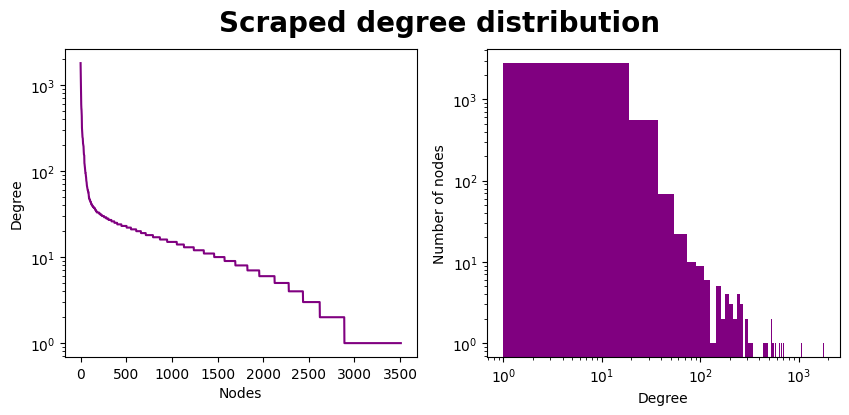

In [165]:
plot_degree_distribution(scraped_G, 'Scraped degree distribution', "purple", save=True, filename=f'{OUT_IMG_DIR}/scraped_degree_distribution.png')

It can indeed be observed that there has been an increase in the average degree of the network during this evolution.

In [166]:
# Scraped graph average degree
print("Average degree of scraped graph: ", scraped_G.number_of_edges() / scraped_G.number_of_nodes())



Average degree of scraped graph:  8.070675406098603


#### **2 - Out degree**

##### Evolution

Top out degree librariesio packages evolution

Top out degree scraped packages evolution

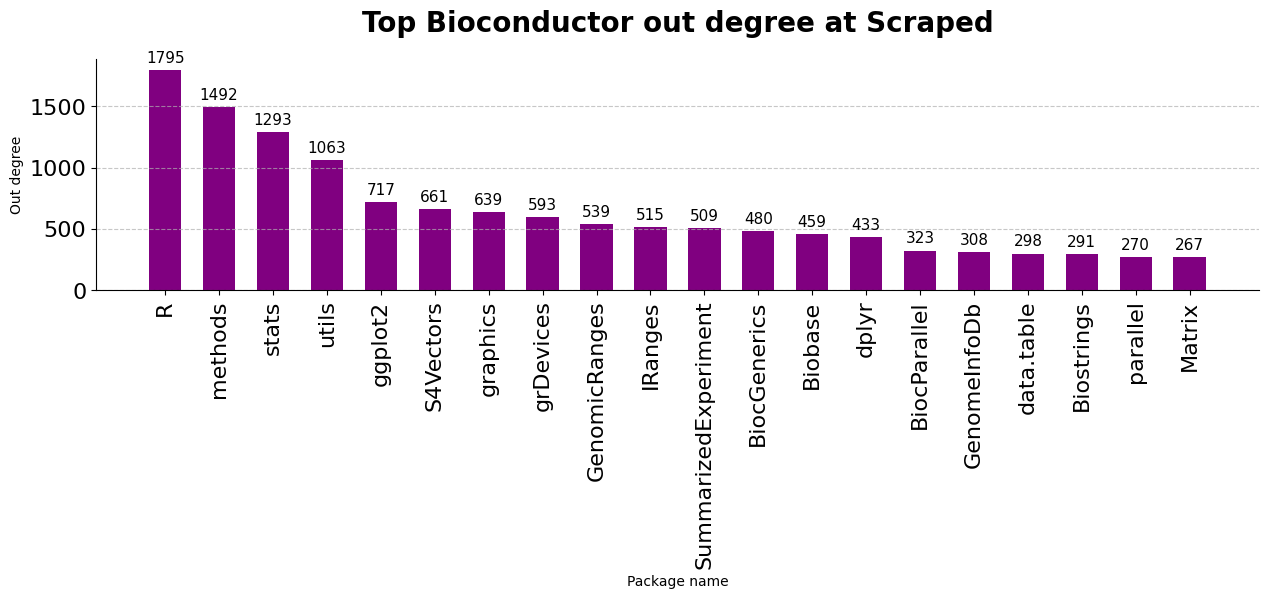

In [167]:
scraped_t20_outd = sorted(scraped_G.out_degree(), key=lambda x: x[1], reverse=True)[:20]

plot_dict(
    d = dict(scraped_t20_outd),
    title = f'Top {REPO_NAME} out degree at Scraped',
    xlabel = 'Package name',
    ylabel = 'Out degree',
    color='purple',
    rotation = 0,
    size = (15, 3),
    offset = 100,
    label_size = 16,
    font_size = 11,
    label_rotation = 90,
    w=0.6,
    save=True,
    filename=f'{OUT_IMG_DIR}/scraped_t20_outd.png',
)






##### Global out degree distribution

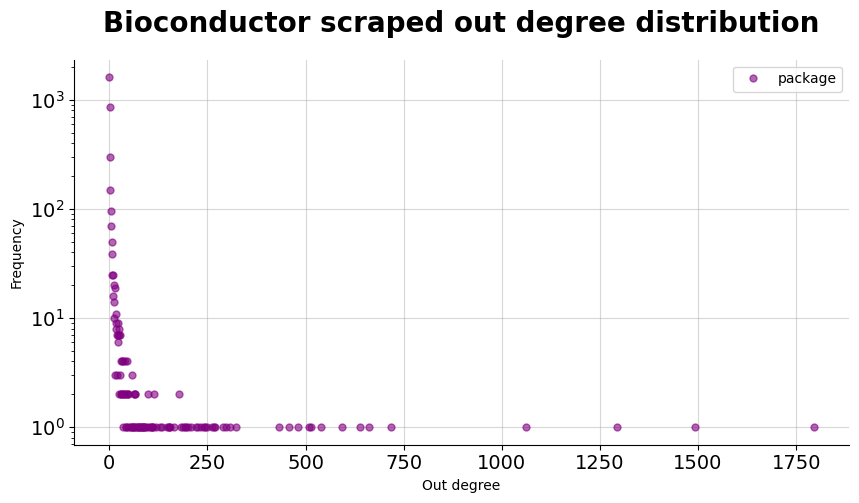

In [168]:


plot_data(
    data = [x[1] for x in scraped_G.out_degree()],
    metric='Out degree',
    title=f'{REPO_NAME} scraped out degree distribution',
    color="purple"
)

#### **3 - In degree**

##### Evolution

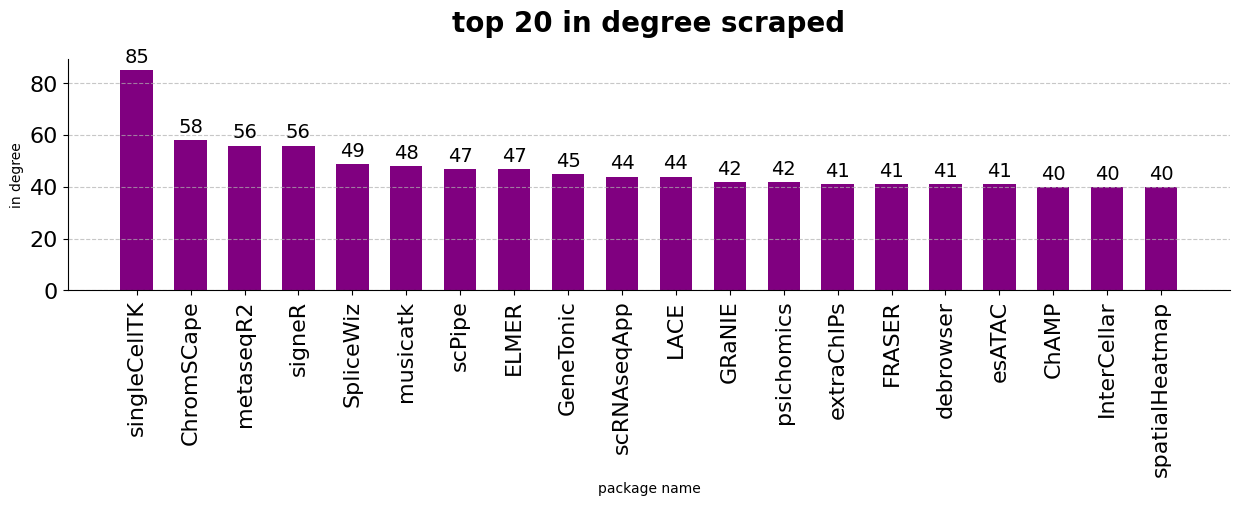

In [169]:
scraped_t20_ind = sorted(scraped_G.in_degree(), key=lambda x: x[1], reverse=True)[:20]

plot_dict(
    d = dict(scraped_t20_ind),
    title = 'top 20 in degree scraped',
    xlabel = 'package name',
    ylabel = 'in degree',
    rotation = 0,
    size = (15, 3),
    offset = 5,
    label_size = 16,
    font_size = 14,
    label_rotation = 90,
    color = 'purple',
    w=0.6
)



##### Global in degree distribution

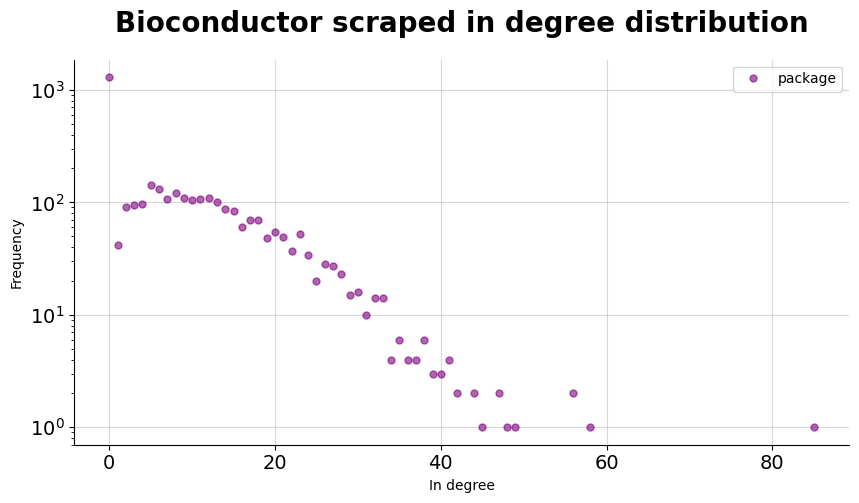

In [170]:
scraped_in_degree = [x[1] for x in scraped_G.in_degree()]
plot_data(scraped_in_degree, 'In degree', f'{REPO_NAME} scraped in degree distribution', 'purple')

#### **4 - Pagerrank**

##### Evolution

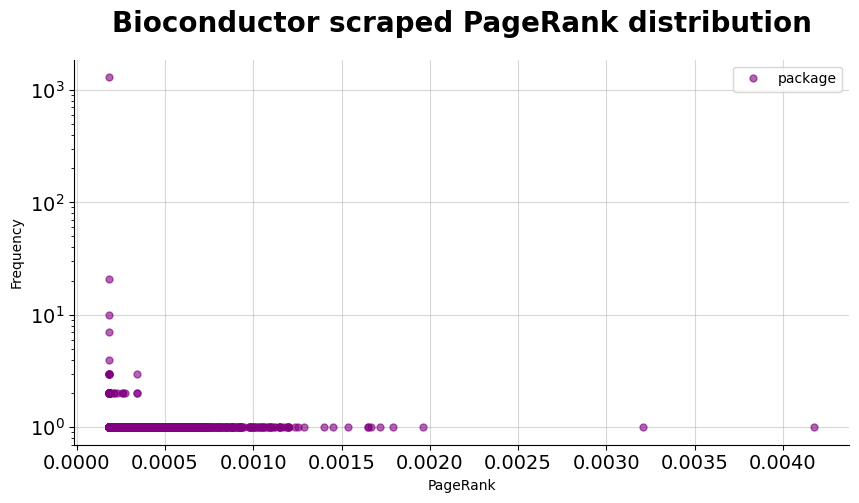

In [171]:
# Pagerank distribution
# ---------------------

# Libraries.io
scraped_pagerank = list(dict(nx.pagerank(scraped_G)).values())
plot_data(scraped_pagerank, 'PageRank', f'{REPO_NAME} scraped PageRank distribution', 'purple')

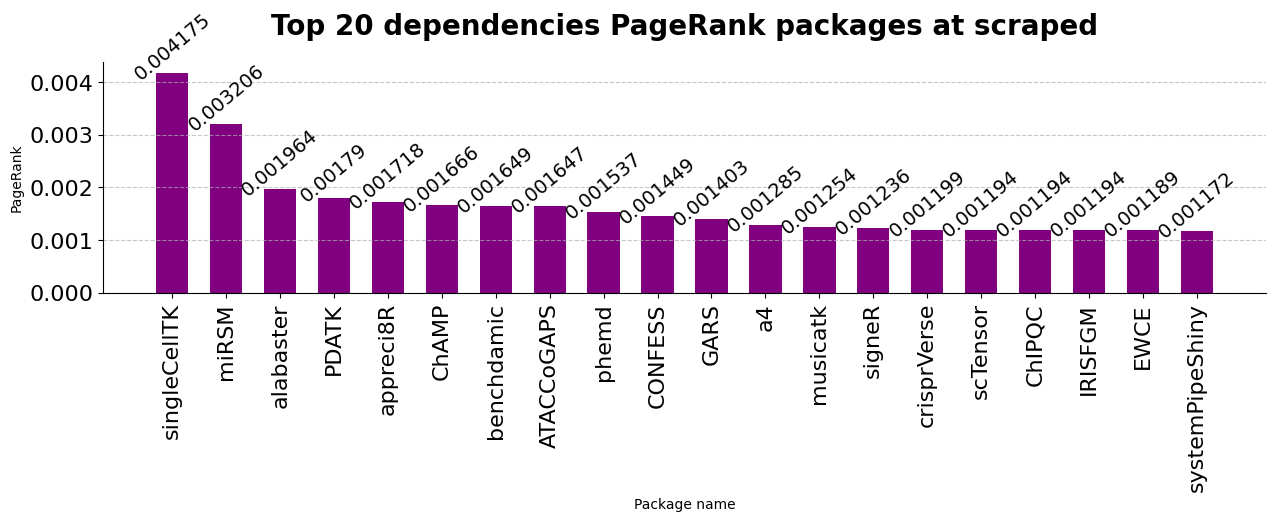

In [172]:
scraped_t20_pr = sorted(nx.pagerank(scraped_G).items(), key=lambda x: x[1], reverse=True)[:20]
scraped_t20_pr = [(x[0], round(x[1], 6)) for x in scraped_t20_pr]

plot_dict(
    d = dict(scraped_t20_pr),
    title = 'Top 20 dependencies PageRank packages at scraped',
    xlabel = 'Package name',
    ylabel = 'PageRank',
    rotation = 40,
    size = (15, 3),
    offset = 0.0005,
    label_size = 16,
    font_size = 14,
    label_rotation = 90,
    w=0.6,
    color='purple'
)




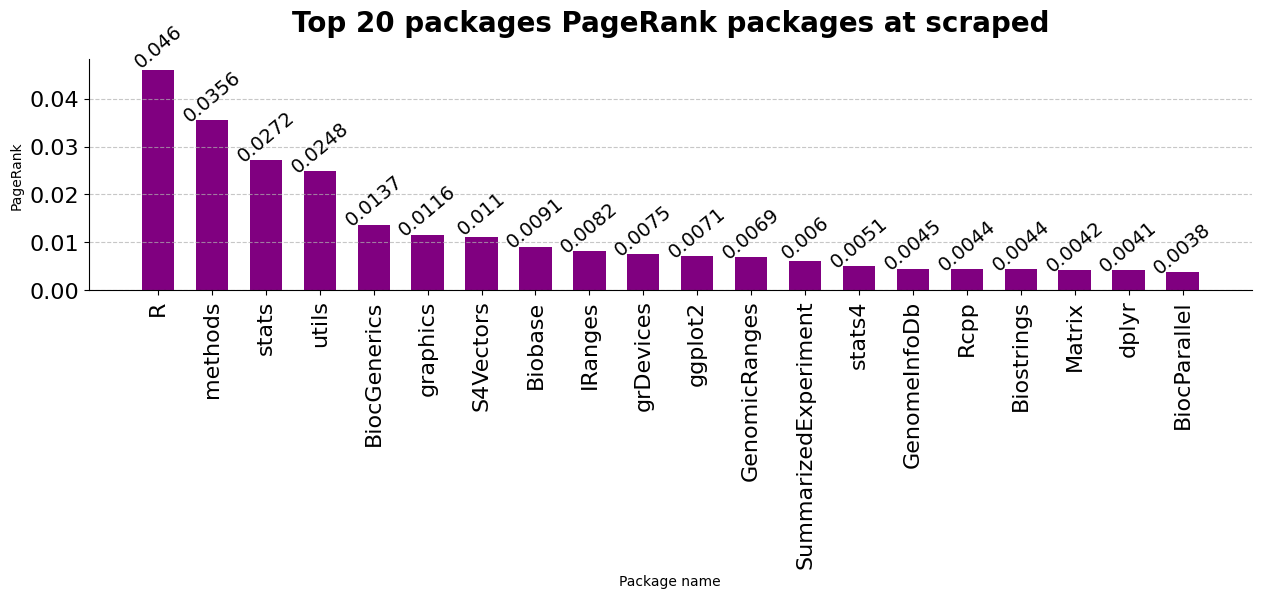

In [173]:
scraped_t20_pr = sorted(nx.pagerank(scraped_G.reverse()).items(), key=lambda x: x[1], reverse=True)[:20]
scraped_t20_pr = [(x[0], round(x[1], 4)) for x in scraped_t20_pr]

plot_dict(
    d = dict(scraped_t20_pr),
    title = 'Top 20 packages PageRank packages at scraped',
    xlabel = 'Package name',
    ylabel = 'PageRank',
    rotation = 40,
    size = (15, 3),
    offset = 0.005,
    label_size = 16,
    font_size = 14,
    label_rotation = 90,
    w=0.6,
    color='purple'
)




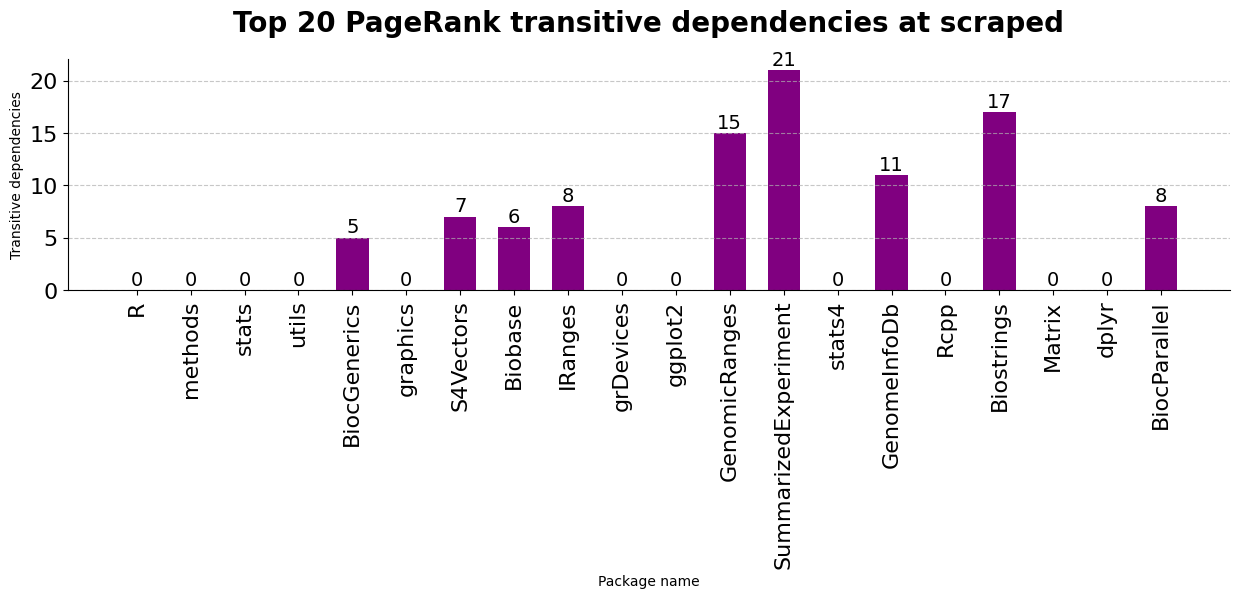

In [174]:
# Top 20 PageRank transitive dependencies at libraries.io
# -------------------------------------------------------


keys = [x[0] for x in scraped_t20_pr]

# get transitive dependencies for each package
transitive_dependencies = {}
for k in keys:

    len_k = len(scraped_model[k].transitive_dependencies())
    transitive_dependencies[k] = len_k


plot_dict(
    d = transitive_dependencies,
    title = 'Top 20 PageRank transitive dependencies at scraped',
    xlabel = 'Package name',
    ylabel = 'Transitive dependencies',
    color='purple',
    rotation = 0,
    offset=1,
    size = (15, 3),
    label_size = 16,
    font_size = 14,
    label_rotation = 90,
    w=0.6
)
    

We can compare other interesting metrics as well.

### **Olivia metrics**

#### **1 - Atack vulnerability**

In [175]:
from olivia.networkmetrics import attack_vulnerability

scraped_model_attack_vulnerability = attack_vulnerability(scraped_model, normalize=True)

print('Attack vulnerability scraped: {}'.format(scraped_model_attack_vulnerability))


Computing Reach
     Processing node: 3K      
Attack vulnerability scraped: 0.6010259333143345


#### **2 - Failure vulnerability**

In [176]:
from olivia.networkmetrics import failure_vulnerability

scraped_model_failure_vulnerability = failure_vulnerability(scraped_model, normalize=True)

print('Failure vulnerability scraped: {}'.format(scraped_model_failure_vulnerability))


Reach retrieved from metrics cache
Failure vulnerability scraped: 0.007072478447920549


#### **3 - Reach**

Reach retrieved from metrics cache


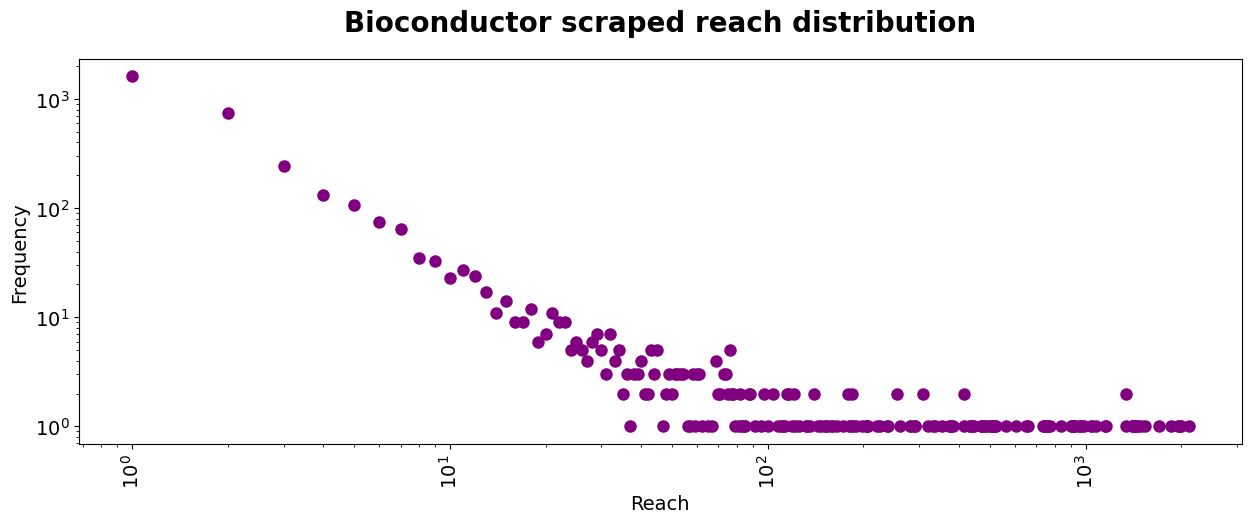

In [177]:
from olivia.packagemetrics import Reach

scraped_reach = scraped_model.get_metric(Reach)
reach_values = scraped_reach.values

# Reach distribution
# ------------------

reach_distribution = Counter(reach_values)
reach_distribution_dict = dict(reach_distribution)

# Sorr by key (reach)
reach_distribution_dict = dict(sorted(reach_distribution_dict.items(), key=lambda x: x[0]))
reach_distribution_dict

# Plot
plt.figure(figsize=(15, 5))
plt.plot(list(reach_distribution_dict.keys()), list(reach_distribution_dict.values()), color='purple', marker='o', linestyle='none', markersize=8)
plt.title(f'{REPO_NAME} scraped reach distribution', fontsize=20, pad=20, fontweight='bold')
plt.xlabel('Reach', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(fontsize=14, rotation=90)
plt.yticks(fontsize=14)
plt.xscale('log')
plt.yscale('log')
plt.show()


**Top reach**

######

In [178]:
scraped_reach.top(20)

[('R', 2109),
 ('stats', 1997),
 ('methods', 1982),
 ('utils', 1957),
 ('graphics', 1860),
 ('BiocGenerics', 1705),
 ('stats4', 1533),
 ('grDevices', 1490),
 ('S4Vectors', 1462),
 ('Biobase', 1437),
 ('tools', 1434),
 ('IRanges', 1410),
 ('zlibbioc', 1406),
 ('RCurl', 1403),
 ('GenomeInfoDbData', 1343),
 ('XVector', 1343),
 ('GenomeInfoDb', 1342),
 ('Matrix', 1155),
 ('matrixStats', 1153),
 ('GenomicRanges', 1075)]

**Bottomb reach**

######

In [179]:
scraped_reach.bottom(20)

[('NanoStringQCPro', 1),
 ('dce', 1),
 ('BioNetStat', 1),
 ('SynExtend', 1),
 ('bcSeq', 1),
 ('cogeqc', 1),
 ('motifcounter', 1),
 ('IMMAN', 1),
 ('polyester', 1),
 ('BCRANK', 1),
 ('sangeranalyseR', 1),
 ('SpatialOmicsOverlay', 1),
 ('GeoDiff', 1),
 ('SpatialDecon', 1),
 ('SynMut', 1),
 ('odseq', 1),
 ('microRNA', 1),
 ('rprimer', 1),
 ('topdownr', 1),
 ('metaseqR2', 1)]

#### **4 - Impact**

In [180]:
from olivia.packagemetrics import Impact

scraped_impact = scraped_model.get_metric(Impact)

Computing Impact
     Processing node: 3K      


Impact retrieved from metrics cache


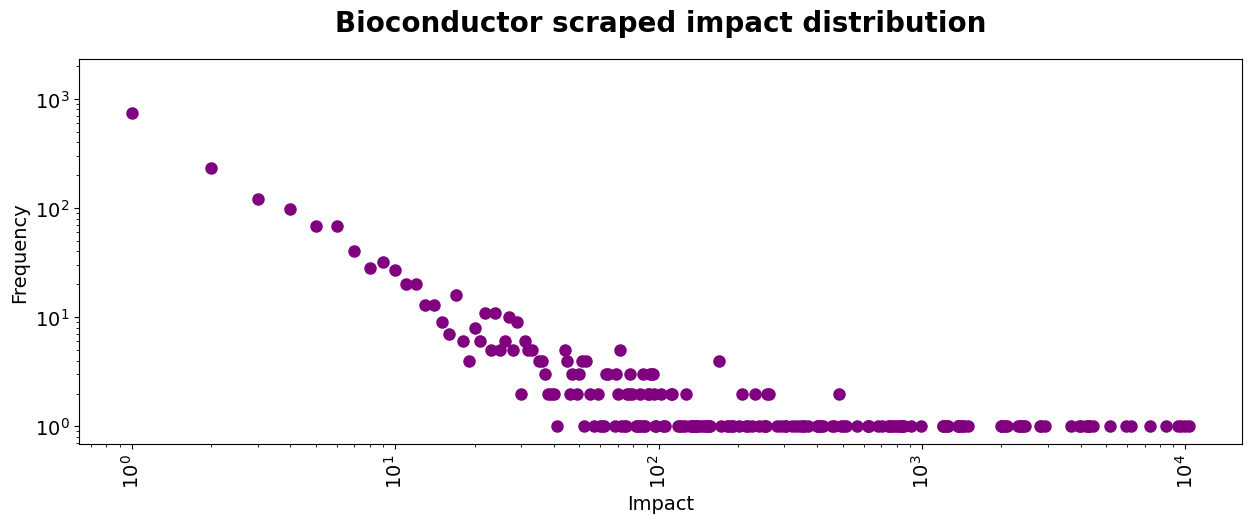

In [181]:
scraped_impact = scraped_model.get_metric(Impact)
impact_values = scraped_impact.values

# Impact distribution
# -------------------

impact_distribution = Counter(impact_values)
impact_distribution_dict = dict(impact_distribution)

# Sorr by key (impact)
impact_distribution_dict = dict(sorted(impact_distribution_dict.items(), key=lambda x: x[0]))
impact_distribution_dict

# Plot
plt.figure(figsize=(15, 5))
plt.plot(list(impact_distribution_dict.keys()), list(impact_distribution_dict.values()), color='purple', marker='o', linestyle='none', markersize=8)
plt.title(f'{REPO_NAME} scraped impact distribution', fontsize=20, pad=20, fontweight='bold')
plt.xlabel('Impact', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(fontsize=14, rotation=90)
plt.yticks(fontsize=14)
plt.xscale('log')
plt.yscale('log')
plt.show()


**Top impact**

######

In [182]:
scraped_impact.top(20)

[('R', 10284),
 ('methods', 9933),
 ('stats', 9617),
 ('utils', 9371),
 ('graphics', 8398),
 ('BiocGenerics', 7357),
 ('stats4', 6235),
 ('S4Vectors', 5942),
 ('IRanges', 5149),
 ('RCurl', 4450),
 ('GenomeInfoDbData', 4302),
 ('GenomeInfoDb', 4298),
 ('tools', 4268),
 ('zlibbioc', 4198),
 ('XVector', 4023),
 ('grDevices', 3927),
 ('Biobase', 3661),
 ('GenomicRanges', 2922),
 ('matrixStats', 2831),
 ('Matrix', 2800)]

**Bottom impact**

######

In [183]:
top10_less_impact_scraped = scraped_impact.bottom(20)
top10_less_impact_scraped

[('NanoStringQCPro', 0),
 ('dce', 0),
 ('BioNetStat', 0),
 ('SynExtend', 0),
 ('bcSeq', 0),
 ('cogeqc', 0),
 ('motifcounter', 0),
 ('IMMAN', 0),
 ('polyester', 0),
 ('BCRANK', 0),
 ('sangeranalyseR', 0),
 ('SpatialOmicsOverlay', 0),
 ('GeoDiff', 0),
 ('SpatialDecon', 0),
 ('SynMut', 0),
 ('odseq', 0),
 ('microRNA', 0),
 ('rprimer', 0),
 ('topdownr', 0),
 ('metaseqR2', 0)]

#### **5 - Surface**

In [184]:
from olivia.packagemetrics import Surface

scraped_surface = scraped_model.get_metric(Surface)

Computing Surface
     Processing node: 0K      


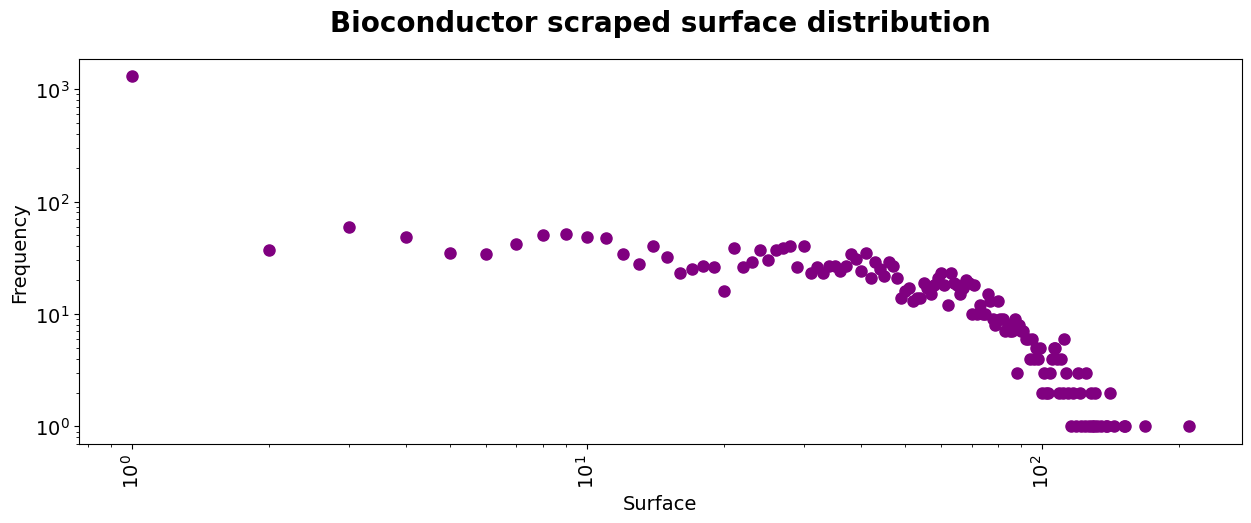

In [185]:
surface_values = scraped_surface.values

# Surface distribution
# --------------------

surface_distribution = Counter(surface_values)
surface_distribution_dict = dict(surface_distribution)

# Sorr by key (surface)
surface_distribution_dict = dict(sorted(surface_distribution_dict.items(), key=lambda x: x[0]))

# Plot
plt.figure(figsize=(15, 5))
plt.plot(list(surface_distribution_dict.keys()), list(surface_distribution_dict.values()), color='purple', marker='o', linestyle='none', markersize=8)
plt.title(f'{REPO_NAME} scraped surface distribution', fontsize=20, pad=20, fontweight='bold')
plt.xlabel('Surface', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(fontsize=14, rotation=90)
plt.yticks(fontsize=14)
plt.xscale('log')
plt.yscale('log')
plt.show()


**Top surface**

######

In [186]:
# Top 10 surface comparison
# -------------------------

scraped_surface.top(20)

[('singleCellTK', 210),
 ('ChAMP', 168),
 ('benchdamic', 152),
 ('miRSM', 151),
 ('methylGSA', 144),
 ('netZooR', 141),
 ('microbiomeMarker', 141),
 ('FLAMES', 139),
 ('DMRcate', 138),
 ('epimutacions', 135),
 ('IRISFGM', 132),
 ('NADfinder', 131),
 ('MEAL', 131),
 ('scTensor', 130),
 ('esATAC', 129),
 ('profileplyr', 128),
 ('MineICA', 128),
 ('MAGAR', 127),
 ('bandle', 125),
 ('seqArchRplus', 125)]

**Bottom surface**

###### 

In [187]:
scraped_surface.bottom(20)

[('whisker', 1),
 ('ellipse', 1),
 ('mixtools', 1),
 ('timsac', 1),
 ('fBasics', 1),
 ('isva', 1),
 ('kpmt', 1),
 ('IlluminaHumanMethylationEPICanno.ilm10b4.hg19', 1),
 ('Illumina450ProbeVariants.db', 1),
 ('ChAMPdata', 1),
 ('testthat', 1),
 ('snowfall', 1),
 ('CCP', 1),
 ('som', 1),
 ('formula.tools', 1),
 ('NetRep', 1),
 ('ggnetwork', 1),
 ('zeallot', 1),
 ('RcppEigen', 1),
 ('remaCor', 1)]

#### Dependencies

In [188]:
from olivia.packagemetrics import DependenciesCount

scraped_dependencies = scraped_model.get_metric(DependenciesCount)

Computing Dependencies Count


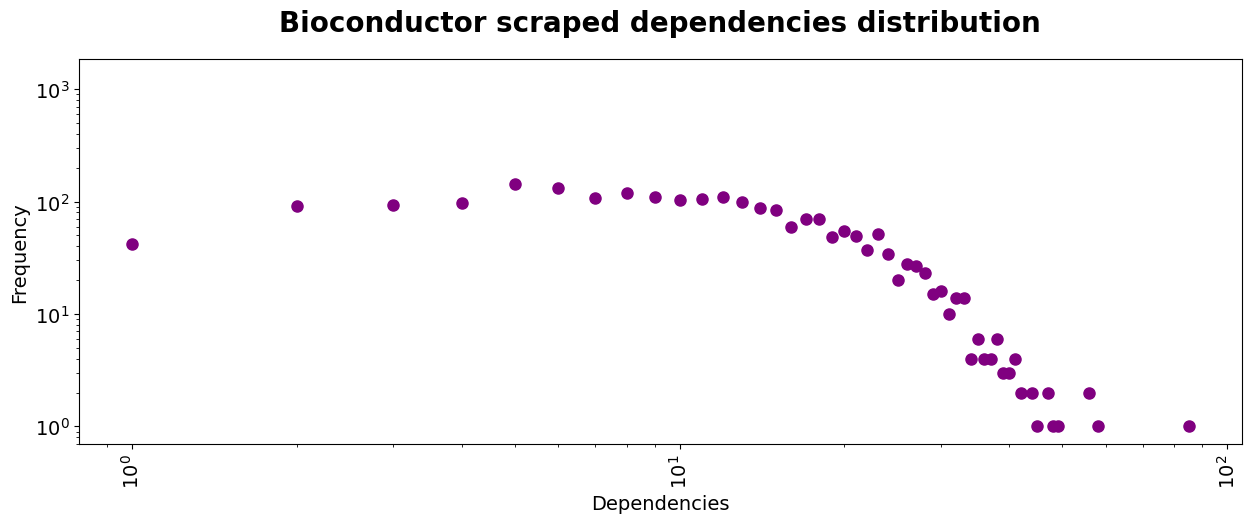

In [189]:
dependencies_values = scraped_dependencies.values

# Dependencies distribution
# -------------------------

dependencies_distribution = Counter(dependencies_values)
dependencies_distribution_dict = dict(dependencies_distribution)

# Sorr by key (dependencies)
dependencies_distribution_dict = dict(sorted(dependencies_distribution_dict.items(), key=lambda x: x[0]))
dependencies_distribution_dict

# Plot
plt.figure(figsize=(15, 5))
plt.plot(list(dependencies_distribution_dict.keys()), list(dependencies_distribution_dict.values()), color='purple', marker='o', linestyle='none', markersize=8)
plt.title(f'{REPO_NAME} scraped dependencies distribution', fontsize=20, pad=20, fontweight='bold')
plt.xlabel('Dependencies', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(fontsize=14, rotation=90)
plt.yticks(fontsize=14)
plt.xscale('log')
plt.yscale('log')
plt.show()


**Top dependencies**

###### 

In [190]:
scraped_dependencies.top(20)

[('singleCellTK', 85),
 ('ChromSCape', 58),
 ('signeR', 56),
 ('metaseqR2', 56),
 ('SpliceWiz', 49),
 ('musicatk', 48),
 ('ELMER', 47),
 ('scPipe', 47),
 ('GeneTonic', 45),
 ('LACE', 44),
 ('scRNAseqApp', 44),
 ('GRaNIE', 42),
 ('psichomics', 42),
 ('FRASER', 41),
 ('extraChIPs', 41),
 ('debrowser', 41),
 ('esATAC', 41),
 ('ChAMP', 40),
 ('InterCellar', 40),
 ('spatialHeatmap', 40)]

**Bottom dependencies**

###### 

In [191]:
scraped_dependencies.bottom(20)

[('nnlasso', 0),
 ('PRIMME', 0),
 ('directPA', 0),
 ('segmented', 0),
 ('shinyTree', 0),
 ('BBmisc', 0),
 ('Rmisc', 0),
 ('adductData', 0),
 ('OrgMassSpecR', 0),
 ('pastecs', 0),
 ('bootstrap', 0),
 ('smoother', 0),
 ('tkrplot', 0),
 ('R2HTML', 0),
 ('SNPlocs.Hsapiens.dbSNP144.GRCh37', 0),
 ('XtraSNPlocs.Hsapiens.dbSNP144.GRCh37', 0),
 ('rsnps', 0),
 ('MafDb.1Kgenomes.phase3.hs37d5', 0),
 ('MafDb.ExAC.r1.0.hs37d5', 0),
 ('R', 0)]

**Evolution**

###### 

#### Dependents

In [192]:
from olivia.packagemetrics import DependentsCount

scraped_dependents = scraped_model.get_metric(DependentsCount)

Computing Dependents Count


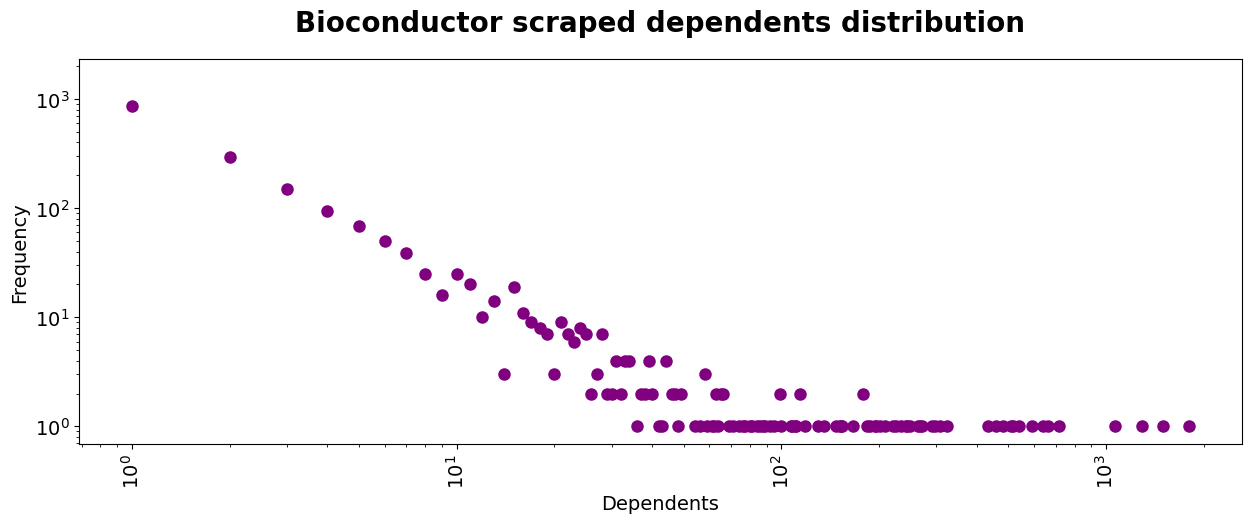

In [193]:
scraped_values = scraped_dependents.values

# Dependents distribution
# -----------------------

dependents_distribution = Counter(scraped_values)
dependents_distribution_dict = dict(dependents_distribution)

# Sorr by key (dependents)
dependents_distribution_dict = dict(sorted(dependents_distribution_dict.items(), key=lambda x: x[0]))
dependents_distribution_dict

# Plot
plt.figure(figsize=(15, 5))
plt.plot(list(dependents_distribution_dict.keys()), list(dependents_distribution_dict.values()), color='purple', marker='o', linestyle='none', markersize=8)
plt.title(f'{REPO_NAME} scraped dependents distribution', fontsize=20, pad=20, fontweight='bold')
plt.xlabel('Dependents', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(fontsize=14, rotation=90)
plt.yticks(fontsize=14)
plt.xscale('log')
plt.yscale('log')
plt.show()




In [194]:
scraped_dependents.top(20)

[('R', 1795),
 ('methods', 1492),
 ('stats', 1293),
 ('utils', 1063),
 ('ggplot2', 717),
 ('S4Vectors', 661),
 ('graphics', 639),
 ('grDevices', 593),
 ('GenomicRanges', 539),
 ('IRanges', 515),
 ('SummarizedExperiment', 509),
 ('BiocGenerics', 480),
 ('Biobase', 459),
 ('dplyr', 433),
 ('BiocParallel', 323),
 ('GenomeInfoDb', 308),
 ('data.table', 298),
 ('Biostrings', 291),
 ('parallel', 270),
 ('Matrix', 267)]

In [195]:
scraped_dependents.bottom(20)


[('mirIntegrator', 0),
 ('idiogram', 0),
 ('imcRtools', 0),
 ('microbiomeExplorer', 0),
 ('metavizr', 0),
 ('metagene', 0),
 ('messina', 0),
 ('keggorthology', 0),
 ('katdetectr', 0),
 ('marr', 0),
 ('lmdme', 0),
 ('mCSEA', 0),
 ('maCorrPlot', 0),
 ('magrene', 0),
 ('maskBAD', 0),
 ('mdp', 0),
 ('metagene2', 0),
 ('methylInheritance', 0),
 ('loci2path', 0),
 ('zenith', 0)]